# VIX-Adjusted Momentum (INDIA)

Replicating [VIX-Adjusted Momentum](https://cssanalytics.wordpress.com/2014/07/29/vix-adjusted-momentum/) using India VIX and the NIFTY 50 index.

In [1]:
library(tidyverse)
library(ggthemes)
library(reshape2)
library(odbc)
library(plutoR)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

indices <- Indices()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘PerformanceAnalytics’

The following obje

In [2]:
startDate <- as.Date('2009-03-03') #the day when India VIX was launched
endDate <- as.Date('2019-06-30')

vixDt <- indices$IndiaVixTimeSeries() %>%
    filter(TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect()
    
nifty50Dt <- indices$NseTimeSeries() %>%
    filter(NAME == 'NIFTY 50' & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect()

allXts <- merge(xts(nifty50Dt$CLOSE, nifty50Dt$TIME_STAMP), xts(vixDt$CLOSE, vixDt$TIME_STAMP))
names(allXts) <- c('NIFTY', 'VIX')

print(allXts[is.na(allXts[,1]) | is.na(allXts[,2])])

     NIFTY VIX


In [3]:
allXts$SMA_200 <- SMA(allXts$NIFTY, 200)
allXts$D_RET <- dailyReturn(allXts$NIFTY)
allXts$D_RET_LAG_1 <- stats::lag(allXts$D_RET, -1) #signal is generated and traded at the close, so use next day's return

allXts$VIX_ADJ_RET <- allXts$D_RET/allXts$VIX
allXts$VIX_ADJ_RET_SMA_200 <- SMA(allXts$VIX_ADJ_RET, 200) 

allXts$ROC_200 <- rollapply(allXts$D_RET, 200, Return.cumulative) #simple compound return or ROC (rate of change) 

allXts <- na.omit(allXts)
print(head(allXts))
print(tail(allXts))

             NIFTY   VIX  SMA_200        D_RET   D_RET_LAG_1    VIX_ADJ_RET
2009-12-24 5178.40 22.94 4354.035  0.006569996  0.0018441990  0.00028639912
2009-12-29 5187.95 24.33 4366.863  0.001844199 -0.0035659557  0.00007579938
2009-12-30 5169.45 24.58 4379.484 -0.003565956  0.0061128360 -0.00014507550
2009-12-31 5201.05 23.35 4392.606  0.006112836  0.0059891753  0.00026179169
2010-01-04 5232.20 23.73 4405.666  0.005989175  0.0087343756  0.00025238834
2010-01-05 5277.90 22.21 4419.190  0.008734376  0.0007389303  0.00039326320
           VIX_ADJ_RET_SMA_200   ROC_200
2009-12-24       0.00009800198 0.9746797
2009-12-29       0.00009838097 0.9783214
2009-12-30       0.00009663322 0.9542757
2009-12-31       0.00010106292 1.0184926
2010-01-04       0.00010011540 0.9969086
2010-01-05       0.00010427622 1.0511435
              NIFTY     VIX  SMA_200         D_RET   D_RET_LAG_1    VIX_ADJ_RET
2019-06-20 11831.75 14.0000 11095.72  0.0120002224 -0.0090984005  0.00085715874
2019-06-21 11724.10 1

In [4]:
#go long only if the index is above its 200-day average
allXts$SMA_STRAT <- ifelse(allXts$NIFTY > allXts$SMA_200, allXts$D_RET_LAG_1, 0) 

#go long only if the simple average (VIX-Adjusted Momentum) > 0
allXts$VIX_STRAT <- ifelse(allXts$VIX_ADJ_RET_SMA_200 > 0, allXts$D_RET_LAG_1, 0) 

#go long only if the ROC > 0
allXts$ROC_200_STRAT <- ifelse(allXts$ROC_200 > 0, allXts$D_RET_LAG_1, 0)

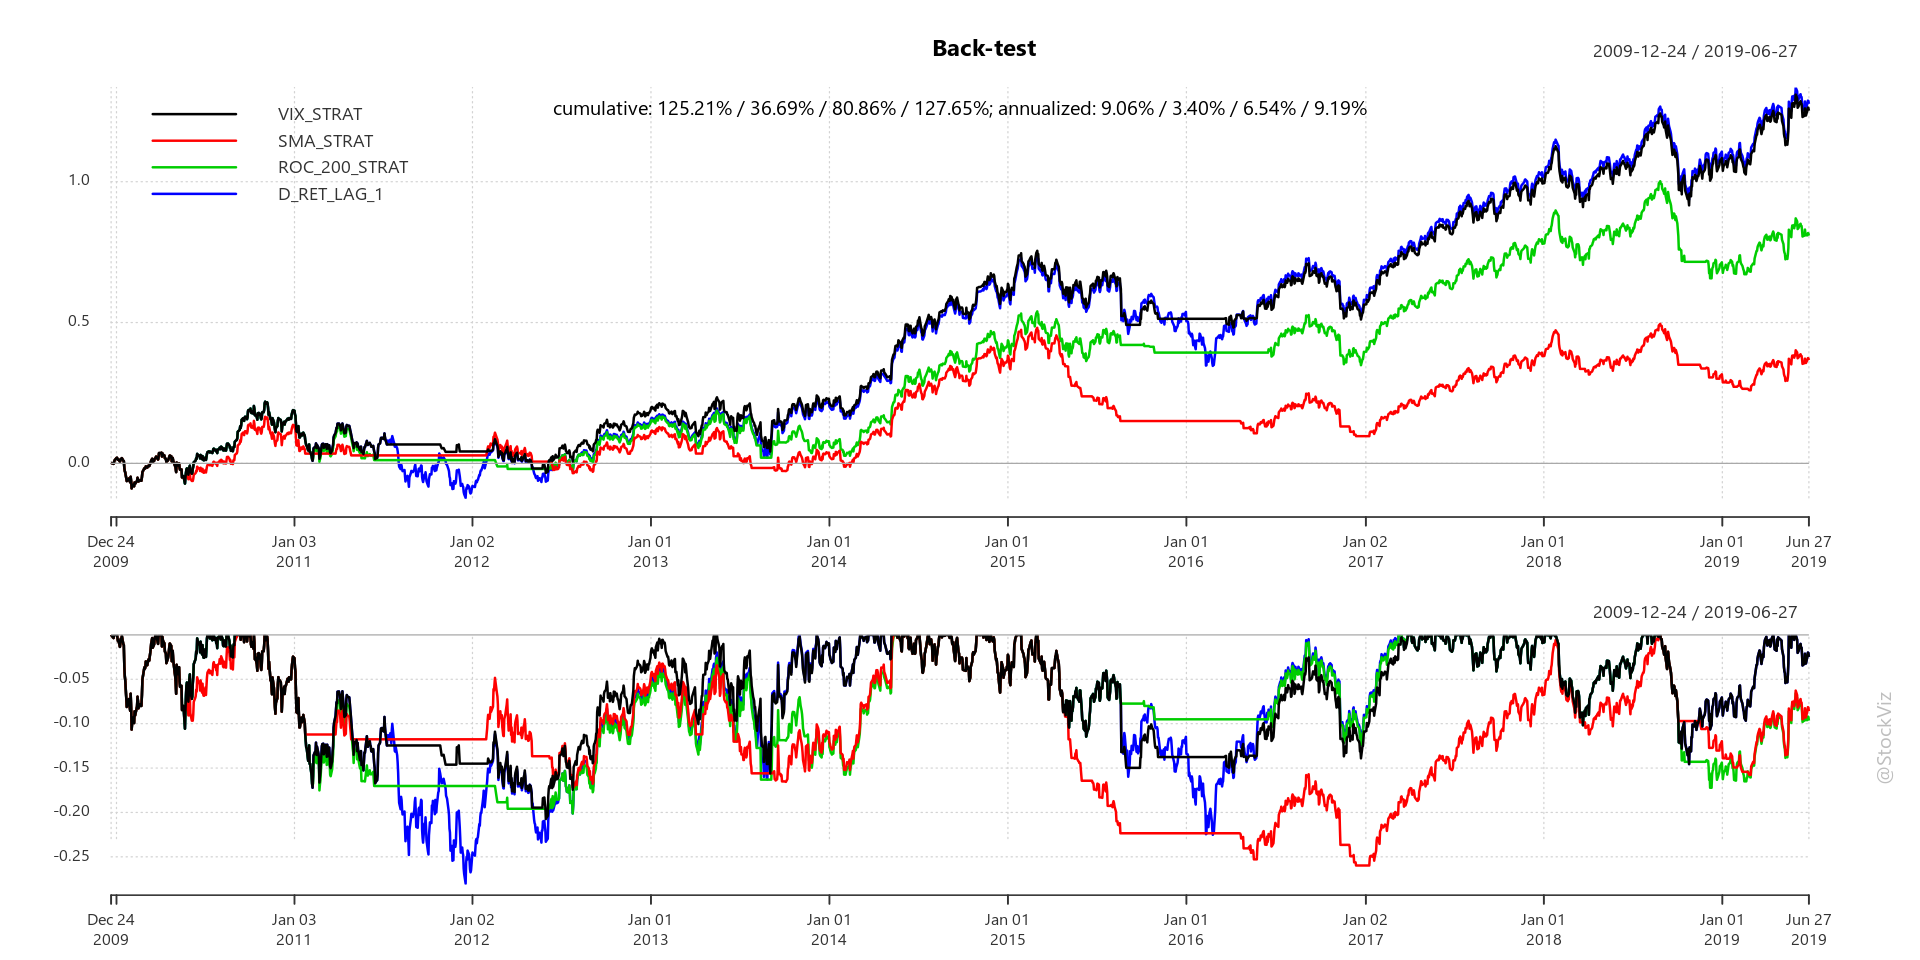

In [5]:
#plot returns
toPlot <- merge(allXts$VIX_STRAT, allXts$SMA_STRAT, allXts$ROC_200_STRAT, allXts$D_RET_LAG_1)
Common.PlotCumReturns(toPlot, "Back-test", "")

In [6]:
#calculate annual returns

byYearDf <- data.frame(T=0, VIX_MOM=0.0, SMA=0.0, ROC=0.0, BH=0.0)

allYears <- unique(year(index(allXts)))
for(yr in allYears){
    byYearDf <- rbind(byYearDf,
                    c(yr, as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'VIX_STRAT'])),
                        as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'SMA_STRAT'])),
                        as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'ROC_200_STRAT'])),
                        as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'D_RET_LAG_1']))))
}

byYearDf <- byYearDf[-1,]
print(byYearDf)

      T    VIX_MOM        SMA         ROC         BH
2  2009   1.038931   1.038931   1.0389309   1.038931
3  2010  17.686633  12.514723  17.6866328  17.686633
4  2011 -12.349590  -9.541756 -14.9335901 -24.698746
5  2012  13.931431   7.418435  12.9133781  28.340972
6  2013   3.514348  -6.066451  -5.5739313   5.894956
7  2014  31.457634  31.457634  31.4576341  31.457634
8  2015  -6.347899 -15.667298  -1.7263752  -3.872525
9  2016   3.257257  -4.675845   0.1138283   2.716245
10 2017  27.581759  25.902444  27.5817593  27.581759
11 2018   4.547436  -4.655957  -3.6968017   4.547436
12 2019   8.054463   3.840349   5.5301819   8.054463


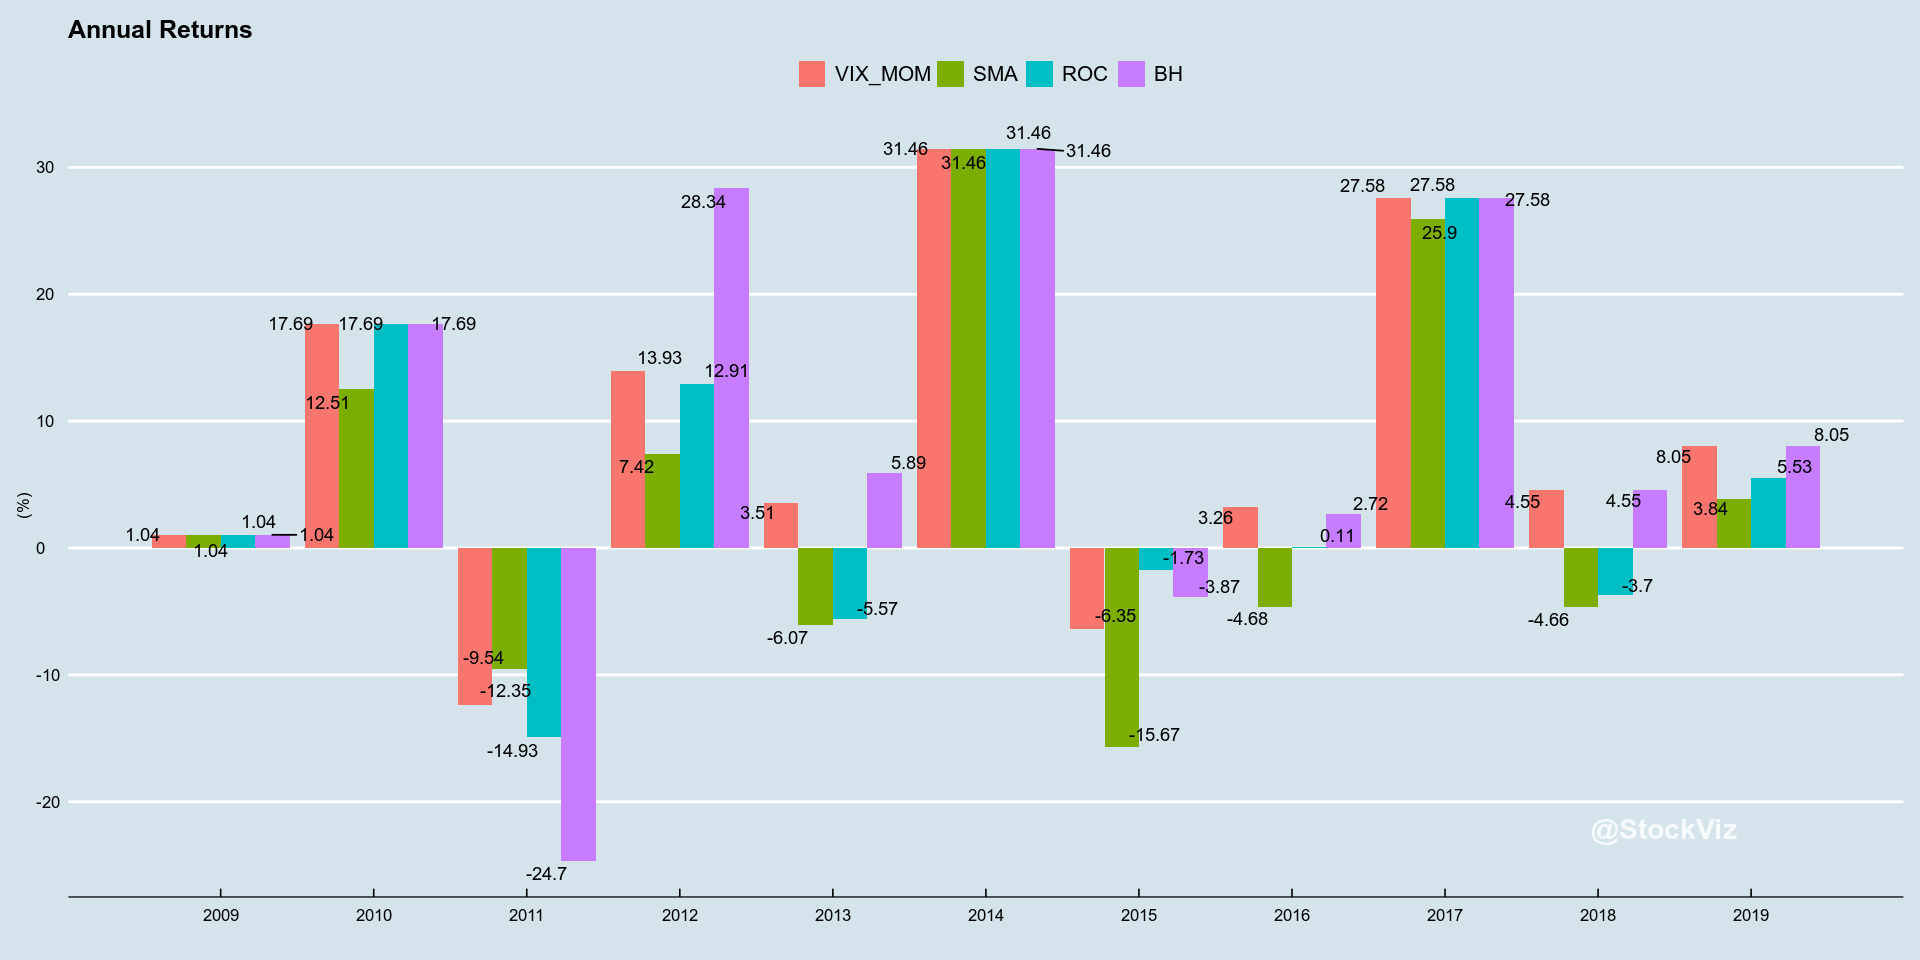

In [7]:
#plot annual returns

ggplot(melt(byYearDf, id='T'), aes(x=T, y=value, fill=variable)) +
    theme_economist() +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(labels=byYearDf$T, breaks=byYearDf$T) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=sprintf("Annual Returns")) +
    annotate("text", x=max(byYearDf$T), y=min(sapply(byYearDf[,-1], min, na.rm=T)), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)